##### ETL Processing With Python & SQLAlchemy

In [1]:
import sqlite3
import pandas as pd
import ast
import matplotlib.pyplot as plt
import sqlite3 as db
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,20)

In [2]:
class DBConnection:

    def __init__(self):
        self.connection = sqlite3.connect("tv_shows_api.db")
        self.cursor = self.connection.cursor()
    
    def close_connection(self):
        self.connection.close()

    def get_cursor(self):
        return self.cursor
    
    def commit(self):
        self.connection.commit()

In [3]:
def create_database():

    df_shows = pd.read_csv("..\df_shows.csv")
    df_episodes = pd.read_csv("..\dataframe_episodes.csv")
    df_webchannel = pd.read_csv("..\df_webchannel.csv")
    db = DBConnection()
    df_episodes.to_sql("episodes", db.connection, if_exists="replace", index=False)
    df_shows.to_sql("shows", db.connection, if_exists="replace", index=False)
    df_webchannel.to_sql("webchannel", db.connection, if_exists="replace", index=False)
    db.close_connection()

In [4]:
create_database()

### ETL

##### Preprocessing of Extract

In [5]:
# Function to extract table to a pandas DataFrame

def extract_information(table_name):
    try:
        db = DBConnection()
        query = (f"SELECT * from {table_name}")
        df_episodes = pd.read_sql_query(query, db.connection)
        return df_episodes
    except Exception as error:
        print(error, "Error: Database connection")
    

##### Preprocessing of Transforming

1. averageRuntime por tipo (type) por mes. 
2. Cantidad de series emitidas por género por mes. 
3. Porcentaje por país, con respecto al total de series emitidas por mes. 
4. Rating promedio de series por país y género por mes.

In [6]:
#Function to get the averageRuntime by type and month

def transform_average_runtime(df):
    df_transform_average_runtime = df[["type", "averageRuntime", "premiered"]]
    df_transform_average_runtime["premiered"] = df_transform_average_runtime["premiered"].apply(pd.to_datetime)
    df_transform_average_runtime["premiered"] = pd.to_datetime(df_transform_average_runtime["premiered"]).dt.month_name()
    df_transform_average_runtime = df_transform_average_runtime.groupby(['type','premiered']).count().unstack('premiered')
    return df_transform_average_runtime

In [7]:
#Function to get the number of shows by genre and month


def transform_shows_by_month(df):

    df_shows_by_month = df[["show_id", "genres", 'premiered']]
    df_shows_by_month["premiered"] = df_shows_by_month["premiered"].apply(pd.to_datetime)
    df_shows_by_month["premiered"] = pd.to_datetime(df_shows_by_month["premiered"]).dt.month_name()
    df_shows_by_month["genres"] = df_shows_by_month["genres"].apply(ast.literal_eval)
    df_shows_by_month["genres"] = df_shows_by_month["genres"].apply(lambda row: "NoGenre" if len(row) == 0 else row)
    res = df_shows_by_month.set_index(['show_id', 'premiered'])['genres'].apply(pd.Series).stack()
    res = res.reset_index()
    res.columns = ['show_id','premiered','sample_num','genres']
    df_shows_genre_month = res[["show_id", "premiered", "genres"]]
    df_shows_genre_month = df_shows_genre_month.groupby(['premiered','genres']).count().unstack('premiered')
    return df_shows_genre_month

In [8]:
#Function to get the number of shows by country and month


def transform_shows_by_country(df_shows, df_webchannel):
    
    df_new = df_shows[["show_id", "webchannnel_id", 'premiered']]
    df_new["premiered"] = df_new["premiered"].apply(pd.to_datetime)
    df_new["premiered"] = pd.to_datetime(df_new["premiered"]).dt.month_name()
    df_new.webchannnel_id = df_new.webchannnel_id.apply(lambda row: 0 if row == '[]' else row)
    df_new['webchannnel_id']=pd.to_numeric(df_new['webchannnel_id'])
    df_webchannel['id']=df_webchannel['id'].astype(int)
    df_transform_shows_by_country = pd.merge(df_new,df_webchannel,left_on='webchannnel_id', right_on='id')
    df_transform_shows_by_country = df_transform_shows_by_country[["show_id", "premiered", "country"]]
    df_transform_shows_by_country = df_transform_shows_by_country.groupby(['country','premiered']).count().unstack('premiered')
    return df_transform_shows_by_country

##### Preprocessing of Loading
Loading finally project to sql


In [9]:
# Function to loading a pandas dataframe into table in database

def load_information(df, table_name:str):
    try:
        db = DBConnection()
        df.to_sql(table_name, db.connection, if_exists="replace")


    except Exception as error:
        print(error, "Error: Database connection")
    finally:
        db.close_connection()
   

#### Creating functions for ETL

In [10]:
df_episodes = extract_information("episodes")
df_shows = extract_information("shows")
df_webchannel = extract_information("webchannel")

In [11]:
df_transform_average_runtime = transform_average_runtime(df_shows)
df_transform_average_runtime

averageRuntime                                                   \
premiered            April August December February January July June March   
type                                                                          
Animation              7.0    2.0     16.0      1.0     7.0  8.0  4.0   6.0   
Award Show             NaN    NaN      1.0      NaN     NaN  NaN  NaN   1.0   
Documentary            5.0    2.0     32.0      2.0     5.0  3.0  5.0   2.0   
Game Show              2.0    NaN      2.0      NaN     1.0  NaN  1.0   1.0   
News                   1.0    0.0      2.0      NaN     NaN  NaN  NaN   1.0   
Panel Show             NaN    1.0      NaN      NaN     NaN  NaN  NaN   NaN   
Reality                NaN    NaN      6.0      2.0     3.0  3.0  2.0   1.0   
Scripted               9.0   10.0     98.0      7.0     7.0  4.0  5.0  10.0   
Sports                 NaN    2.0      2.0      1.0     7.0  2.0  1.0   2.0   
Talk Show              6.0    4.0     10.0      3.0     3.0  3.0  2.0   7.0   
Variety                2.0    2.0      4.0      NaN     1.0  1.0  2.0   1.0   

                                             
premiered    May November October September  
type                                         
Animation    4.0      9.0    10.0       7.0  
Award Show   NaN      NaN     NaN       NaN  
Documentary  5.0      9.0     6.0       6.0  
Game Show    NaN      1.0     2.0       4.0  
News         NaN      1.0     NaN       NaN  
Panel Show   NaN      NaN     NaN       NaN  
Reality      1.0     20.0    10.0       4.0  
Scripted     3.0     51.0    33.0      16.0  
Sports       NaN      1.0     1.0       1.0  
Talk Show    9.0      5.0     7.0       3.0  
Variety      1.0      3.0     2.0       2.0

1. averageRuntime by type and month

<AxesSubplot:xlabel='type'>

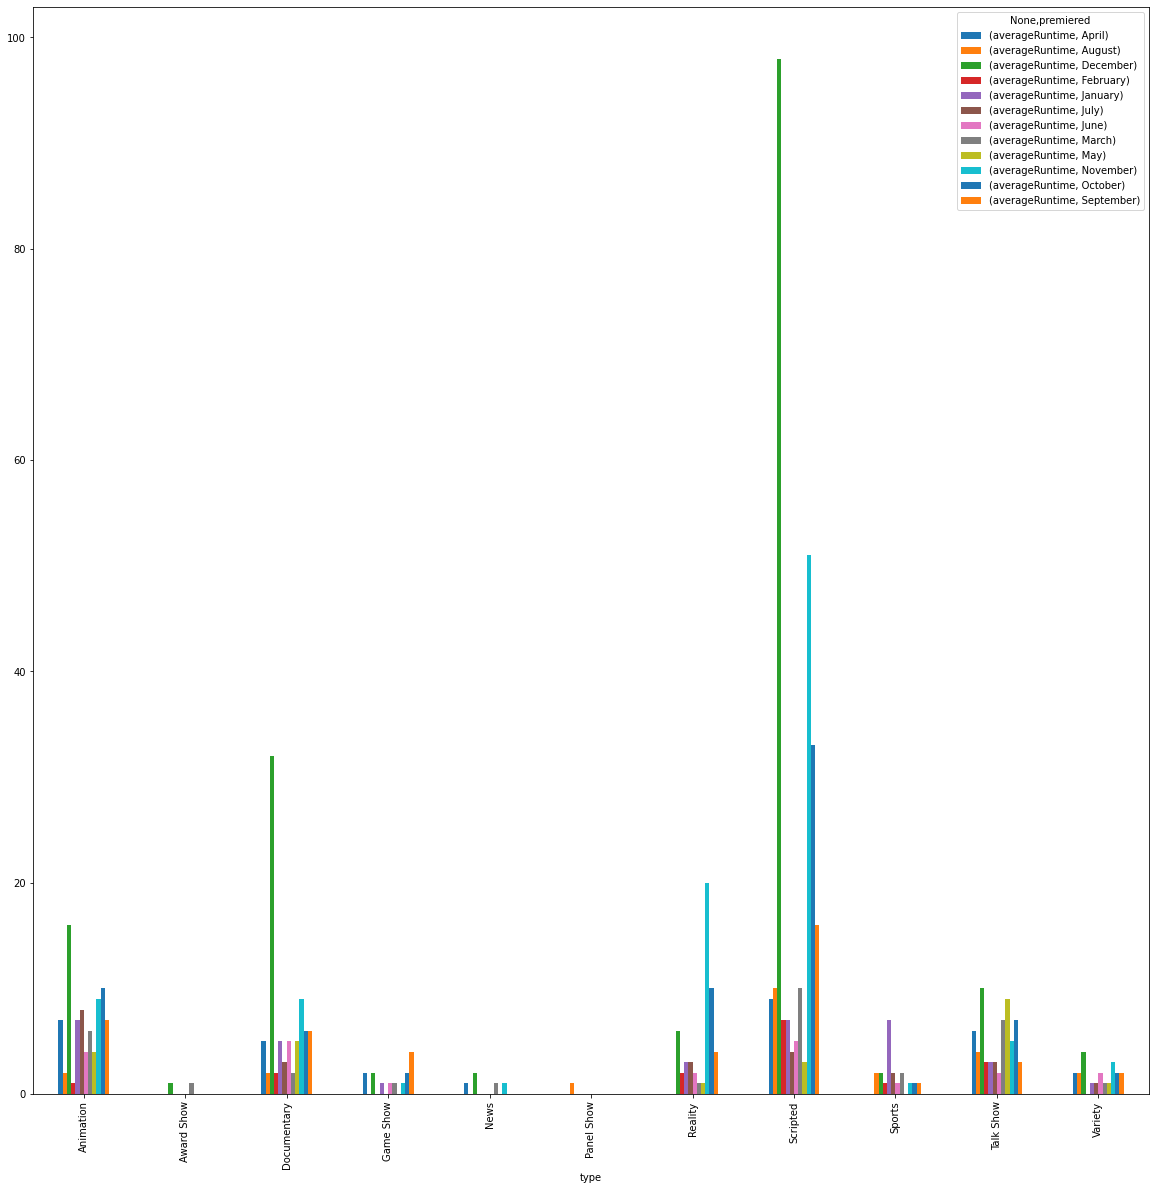

In [12]:
df_transform_average_runtime.plot.bar()

In [13]:
df_transform_shows_by_month = transform_shows_by_month(df_shows)
df_transform_shows_by_month

show_id                                                    \
premiered         April August December February January July  June March   
genres                                                                      
Action              4.0    2.0      5.0      1.0     3.0  2.0   NaN   1.0   
Adult               1.0    NaN      NaN      NaN     NaN  NaN   NaN   NaN   
Adventure           4.0    2.0      9.0      NaN     3.0  4.0   NaN   3.0   
Anime               3.0    1.0      3.0      NaN     3.0  4.0   1.0   2.0   
Children            2.0    3.0      9.0      1.0     3.0  3.0   4.0   NaN   
Comedy             16.0   11.0     36.0      9.0     7.0  8.0   7.0  10.0   
Crime               1.0    2.0     17.0      1.0     1.0  NaN   1.0   NaN   
DIY                 NaN    1.0      NaN      NaN     1.0  NaN   NaN   NaN   
Drama               6.0    5.0     77.0      1.0     4.0  3.0   1.0   6.0   
Family              NaN    1.0      7.0      3.0     1.0  1.0   2.0   1.0   
Fantasy             1.0    2.0      8.0      1.0     1.0  2.0   1.0   4.0   
Food                1.0    1.0      3.0      NaN     1.0  NaN   NaN   2.0   
History             2.0    NaN      6.0      NaN     NaN  2.0   1.0   1.0   
Horror              NaN    NaN      4.0      NaN     NaN  1.0   2.0   NaN   
Legal               1.0    NaN      NaN      NaN     NaN  NaN   NaN   1.0   
Medical             NaN    NaN      1.0      NaN     1.0  1.0   NaN   1.0   
Music               NaN    1.0     10.0      1.0     1.0  NaN   2.0   NaN   
Mystery             1.0    1.0     17.0      NaN     NaN  NaN   NaN   1.0   
Nature              NaN    NaN      4.0      1.0     NaN  NaN   NaN   NaN   
NoGenre             8.0    6.0     45.0      5.0    16.0  7.0  10.0  11.0   
Romance             4.0    5.0     34.0      NaN     2.0  2.0   2.0   3.0   
Science-Fiction     1.0    NaN      7.0      NaN     NaN  3.0   NaN   1.0   
Sports              1.0    1.0      3.0      NaN     2.0  1.0   NaN   2.0   
Supernatural        2.0    NaN      7.0      NaN     1.0  2.0   NaN   NaN   
Thriller            NaN    NaN     15.0      NaN     NaN  NaN   1.0   NaN   
Travel              NaN    NaN      1.0      NaN     NaN  1.0   NaN   NaN   
War                 1.0    NaN      NaN      NaN     NaN  NaN   NaN   1.0   

                                                  
premiered         May November October September  
genres                                            
Action            1.0     10.0     6.0       3.0  
Adult             NaN      NaN     NaN       NaN  
Adventure         NaN      5.0     1.0       4.0  
Anime             2.0      4.0     7.0       NaN  
Children          NaN      7.0     3.0       5.0  
Comedy           10.0     35.0    14.0      17.0  
Crime             NaN      7.0     8.0       2.0  
DIY               NaN      NaN     NaN       NaN  
Drama             NaN     29.0    24.0      13.0  
Family            1.0      3.0     3.0       2.0  
Fantasy           NaN      7.0     4.0       4.0  
Food              1.0      5.0     4.0       1.0  
History           NaN      5.0     1.0       1.0  
Horror            NaN      3.0     3.0       2.0  
Legal             NaN      NaN     NaN       NaN  
Medical           NaN      NaN     NaN       NaN  
Music             NaN      5.0     3.0       3.0  
Mystery           NaN      7.0     4.0       NaN  
Nature            NaN      1.0     NaN       NaN  
NoGenre          11.0     21.0    19.0      14.0  
Romance           NaN     15.0    18.0       4.0  
Science-Fiction   1.0      4.0     4.0       1.0  
Sports            NaN      3.0     6.0       2.0  
Supernatural      NaN      NaN     2.0       1.0  
Thriller          NaN      9.0     1.0       2.0  
Travel            NaN      3.0     1.0       2.0  
War               1.0      NaN     1.0       2.0

2. Number of shows by genre and month


<AxesSubplot:xlabel='genres'>

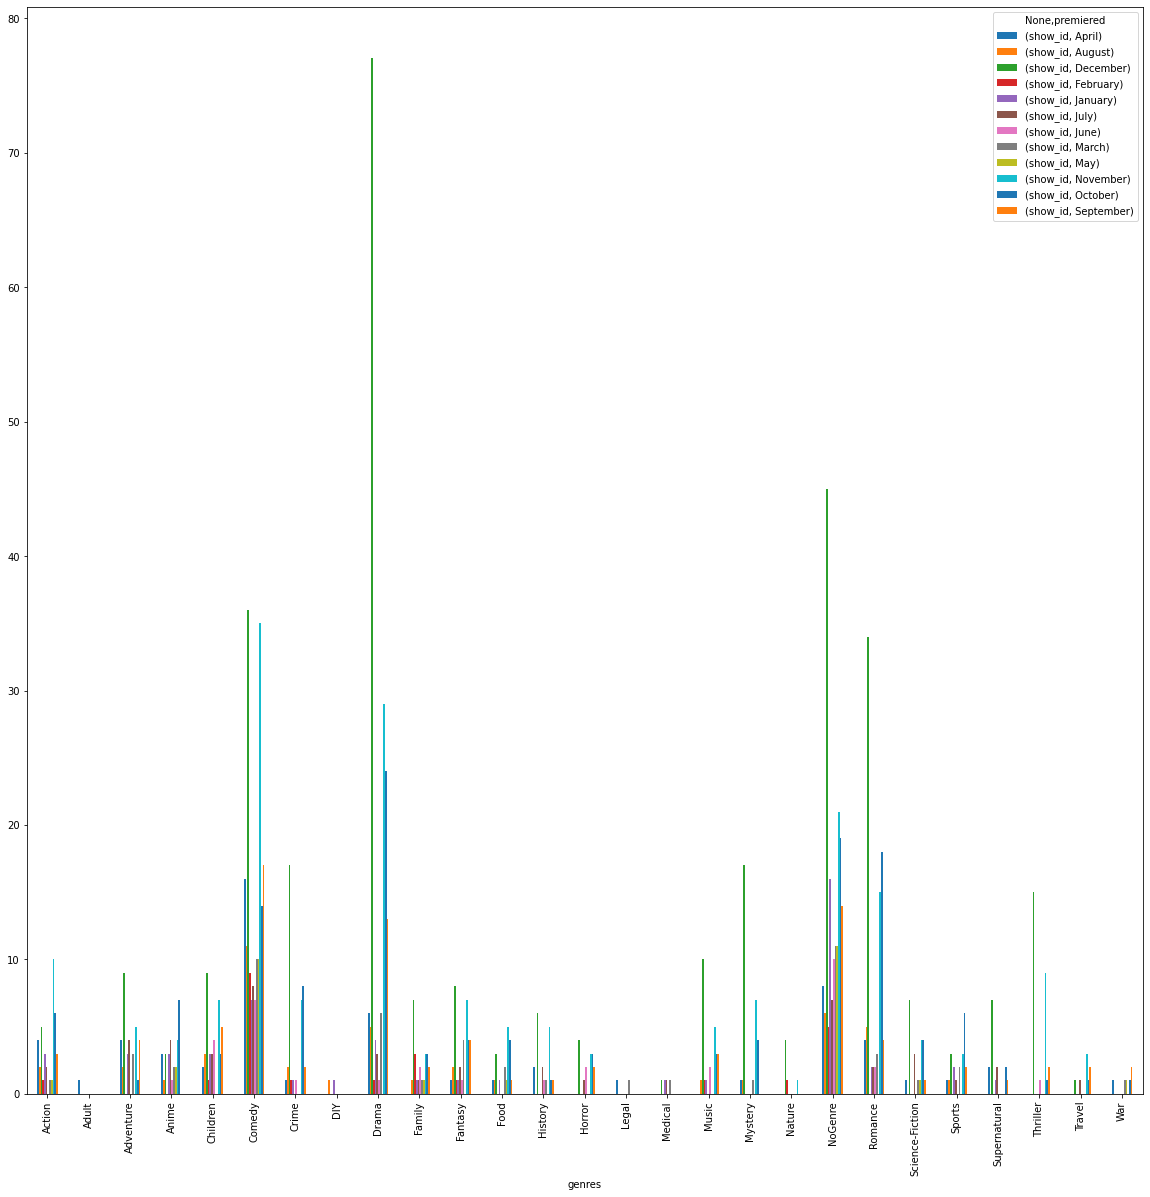

In [14]:
df_transform_shows_by_month.plot.bar()

In [15]:
df_transform_shows_by_country = transform_shows_by_country(df_shows, df_webchannel)
df_transform_shows_by_country

show_id                                         \
premiered                   April August December February January  July   
country                                                                    
Australia                     NaN    NaN      NaN      1.0     NaN   NaN   
Bangladesh                    NaN    NaN      1.0      NaN     NaN   NaN   
Belgium                       1.0    2.0      6.0      NaN     NaN   1.0   
Brazil                        NaN    1.0      NaN      NaN     NaN   NaN   
Canada                        1.0    1.0      NaN      1.0     NaN   NaN   
China                         4.0    2.0     58.0      2.0     3.0   4.0   
Denmark                       NaN    1.0      NaN      NaN     NaN   NaN   
Egypt                         NaN    NaN      5.0      NaN     2.0   NaN   
Finland                       NaN    NaN      NaN      NaN     NaN   NaN   
France                        1.0    NaN      NaN      NaN     NaN   NaN   
Germany                       NaN    NaN      2.0      NaN     3.0   NaN   
Greece                        NaN    NaN      NaN      NaN     NaN   NaN   
Hong Kong                     NaN    NaN      1.0      NaN     NaN   NaN   
India                         1.0    1.0      6.0      NaN     NaN   NaN   
Iran, Islamic Republic of     NaN    NaN      NaN      NaN     NaN   NaN   
Japan                         NaN    NaN      NaN      NaN     2.0   NaN   
Kazakhstan                    NaN    NaN      NaN      NaN     NaN   NaN   
Korea, Republic of            1.0    2.0     13.0      NaN     1.0   NaN   
Malaysia                      NaN    1.0      NaN      NaN     NaN   NaN   
Netherlands                   1.0    NaN      NaN      NaN     NaN   NaN   
Norway                       16.0    6.0     56.0     10.0    13.0  10.0   
Philippines                   NaN    NaN      NaN      NaN     NaN   NaN   
Poland                        1.0    NaN      1.0      NaN     NaN   NaN   
Portugal                      NaN    NaN      2.0      NaN     NaN   NaN   
Russian Federation            NaN    3.0      9.0      1.0     2.0   NaN   
Spain                         NaN    NaN      3.0      NaN     NaN   NaN   
Sweden                        NaN    NaN      1.0      NaN     NaN   NaN   
Taiwan, Province of China     NaN    NaN      2.0      NaN     NaN   NaN   
Thailand                      NaN    NaN      1.0      NaN     NaN   NaN   
Turkey                        NaN    2.0      2.0      1.0     NaN   NaN   
United Kingdom                1.0    NaN      5.0      NaN     1.0   NaN   
United States                 5.0    3.0      7.0      1.0     7.0   9.0   

                                                                        
premiered                  June March   May November October September  
country                                                                 
Australia                   NaN   NaN   NaN      NaN     NaN       NaN  
Bangladesh                  NaN   NaN   NaN      NaN     NaN       NaN  
Belgium                     NaN   1.0   1.0      6.0     1.0       3.0  
Brazil                      1.0   NaN   1.0      1.0     NaN       NaN  
Canada                      NaN   NaN   NaN      NaN     NaN       NaN  
China                       2.0   2.0   2.0     16.0    13.0       4.0  
Denmark                     NaN   NaN   NaN      NaN     NaN       NaN  
Egypt                       NaN   2.0   NaN      4.0     NaN       NaN  
Finland                     NaN   NaN   NaN      1.0     NaN       NaN  
France                      NaN   NaN   NaN      NaN     NaN       NaN  
Germany                     NaN   NaN   NaN      1.0     2.0       NaN  
Greece                      1.0   NaN   NaN      NaN     NaN       NaN  
Hong Kong                   NaN   NaN   NaN      2.0     NaN       NaN  
India                       NaN   NaN   NaN      1.0     NaN       NaN  
Iran, Islamic Republic of   NaN   NaN   NaN      1.0     NaN       NaN  
Japan                       NaN   NaN   NaN      Na

3. Number of shows by country and month

<AxesSubplot:xlabel='country'>

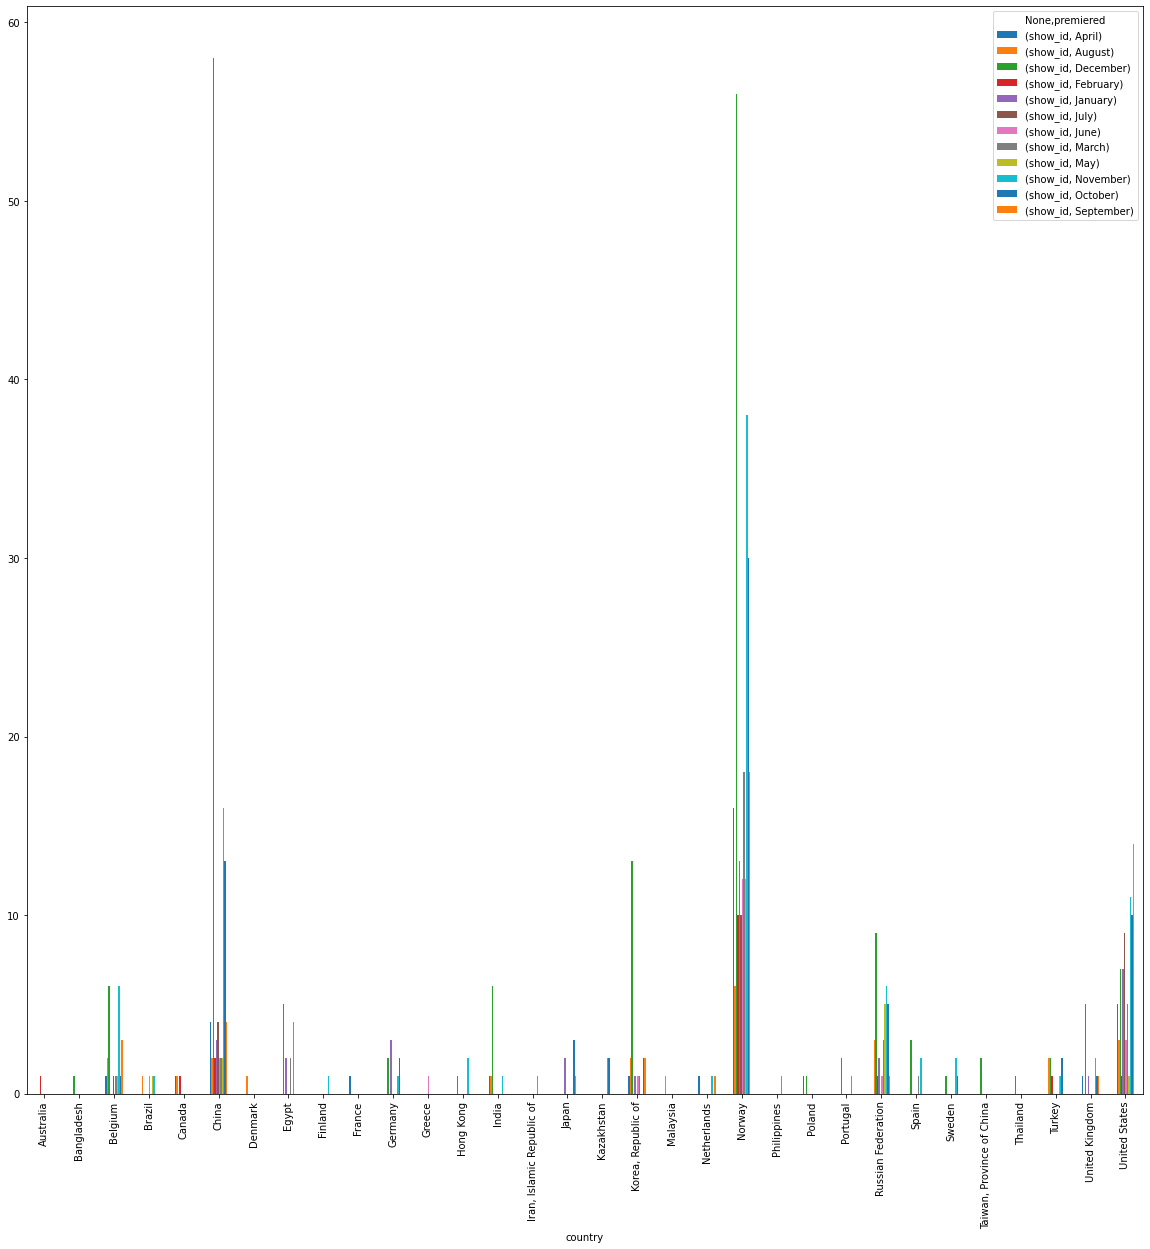

In [16]:
df_transform_shows_by_country.plot.bar()

In [17]:
load_information(df_transform_average_runtime, "df_transform_average_runtime")
load_information(df_transform_shows_by_month, "df_transform_shows_by_month")
load_information(df_transform_shows_by_country, "df_transform_shows_by_country")